**MDS7203 Modelos Generativos Profundos, Primavera 2023**

# Proyecto Final: Bayesian Flow Networks

**Profesor**: Felipe Tobar.  
**Auxiliares**: Cristóbal Alcázar, Camilo Carvajal Reyes.  
**Ayudante**: Joaquín Barceló.  
**Nombres**: Arturo Lazcano y Javier Santidrián.

## Imports y creación de dataset (MNIST)

En esta sección se importan las librerías necesarias para ejecutar este proyecto.  
Por otro lado, se definen las funciones para binarizar los conjuntos de datos, en este caso, de MNIST.  
Notar que se usarán 2 dataset diferentes: MNIST usual (dígitos) que pasa por una binarización con el objetivo de que un píxel tenga valores 0 o 1 (negro/blanco), mientras que el segundo dataset es una modificación de MNIST encontrada en [este github](https://github.com/shaohua0116/MultiDigitMNIST) que consiste en una imagen de un 2 dígitos en vez de 1, donde este dataset también es binarizado para la utilización de la Bayesian Flow Network.

In [1]:
# Import básicos
import torch
import numpy as np
import time
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW, Adam, SGD
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
# Se necesita subir el archivo "generator.py" del enlace
# https://github.com/shaohua0116/MultiDigitMNIST

# Creación de dataset tipo MNIST con dobles dígitos
!python generator.py --num_image_per_class 1000 --multimnist_path ./dataset/double_mnist --num_digit 2 --image_size 64 64

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  84.5M      0 --:--:-- --:--:-- --:--:-- 85.1M
Unzip  train-images-idx3-ubyte.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   981k      0 --:--:-- --:--:-- --:--:-- 1007k
Unzip  train-labels-idx1-ubyte.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  57.0M      0 --:--:-- --:--:-- --:--:-- 58.2M
Unzip  t10k-images-idx3-ubyte.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     

In [3]:
# Moving average para entrenamiento de la red
!pip install torch-ema
import torch_ema

In [4]:
# Define the data transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the pixel values to [-1, 1]
    #transforms.Lambda(lambda x: torch.round((x + 1) / 2).to(torch.int64)) # Discretize data
])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 164212745.16it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9952813.56it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 52947460.51it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15835851.01it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# Clase para leer MNIST binarizado

class DynamicallyBinarizedMNIST(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(DynamicallyBinarizedMNIST, self).__init__(root, train=train, transform=transform,
                                                        target_transform=target_transform, download=download)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])

        if self.transform is not None:
            img = self.transform(img)

        return img, target

# Función para generar imágenes con pixel 0 o 1
def collate_dynamic_binarize(batch):
    # Collate function that samples a binarization probability for each batch
    images, targets = zip(*batch)
    binarization_probs = torch.rand(len(images))

    binarized_images = []
    for img, prob in zip(images, binarization_probs):
        binarized_img = (img > prob).float()
        binarized_images.append(binarized_img)

    return torch.stack(binarized_images)[:, None, ...].to(torch.int64), torch.tensor(targets)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dynamically binarized MNIST dataset
train_dataset = DynamicallyBinarizedMNIST(root='./data', train=True, download=True) #transform=transform
test_dataset = DynamicallyBinarizedMNIST(root='./data', train=False, download=True) #transform=transform

# Create data loaders with the collate function
batch_size = 512
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                           shuffle=True, collate_fn=collate_dynamic_binarize)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                          shuffle=False, collate_fn=collate_dynamic_binarize)



100%|██████████| 9912422/9912422 [00:00<00:00, 114244723.38it/s]

Extracting ./data/DynamicallyBinarizedMNIST/raw/train-images-idx3-ubyte.gz to ./data/DynamicallyBinarizedMNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 93109680.11it/s]


Extracting ./data/DynamicallyBinarizedMNIST/raw/train-labels-idx1-ubyte.gz to ./data/DynamicallyBinarizedMNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 57770113.74it/s]

Extracting ./data/DynamicallyBinarizedMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/DynamicallyBinarizedMNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15179704.20it/s]


Extracting ./data/DynamicallyBinarizedMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/DynamicallyBinarizedMNIST/raw



In [6]:
# Leer dataset de train, validation y test

dataset_2digit_train = torchvision.datasets.ImageFolder(root="dataset/double_mnist/train",
                                     transform=torchvision.transforms.ToTensor())

dataset_2digit_val = torchvision.datasets.ImageFolder(root="dataset/double_mnist/val",
                                     transform=torchvision.transforms.ToTensor())

dataset_2digit_test = torchvision.datasets.ImageFolder(root="dataset/double_mnist/test",
                                     transform=torchvision.transforms.ToTensor())

In [7]:
# Definir batch size y binarizar dataset a utilizar (train)

batch_size = 512

train_dataset_2 = DynamicallyBinarizedMNIST(root='./dataset', train=True, download=True)
train_loader_2 = torch.utils.data.DataLoader(dataset=dataset_2digit_train, batch_size=batch_size,
                                           shuffle=True, collate_fn=collate_dynamic_binarize)

100%|██████████| 9912422/9912422 [00:00<00:00, 104036031.62it/s]

Extracting ./dataset/DynamicallyBinarizedMNIST/raw/train-images-idx3-ubyte.gz to ./dataset/DynamicallyBinarizedMNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 89730143.57it/s]


Extracting ./dataset/DynamicallyBinarizedMNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/DynamicallyBinarizedMNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 77864122.91it/s]

Extracting ./dataset/DynamicallyBinarizedMNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/DynamicallyBinarizedMNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5013297.04it/s]


Extracting ./dataset/DynamicallyBinarizedMNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/DynamicallyBinarizedMNIST/raw



118


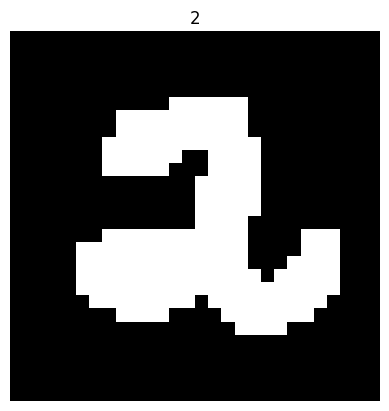

In [ ]:
# Show example MNIST
print(len(train_loader))
for i in train_loader:
  x, y = i
  plt.imshow(x[0][0], cmap='Greys_r', interpolation='nearest')
  plt.axis('off')
  plt.title(y[0].numpy())
  break

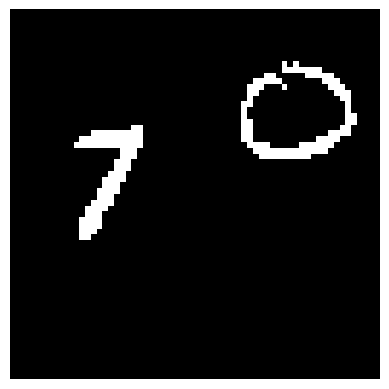

In [9]:
# Show example 2 digit MNIST
plt.imshow(next(iter(train_loader_2))[0][0,0,0,:,:], cmap='Greys_r')
plt.axis('off')
plt.show()

## Funciones de Utilidad

En esta sección se definen funciones que servirán para más adelante. Se encuentran funciones para tomar el tiempo de entrenamiento de las redes neuronales junto con funciones para samplear un dato de cada dataset de entrenamiento, tanto de MNIST usual como de MNIST con dobles dígitos.  
Por otro lado, se definen las semillas y el `device` a utilizar (gpu idealmente).

In [ ]:
# Fijar semilla en librerías
seed = 10
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [ ]:
# Función para tomar tiempo entre épocas del entrenamiento de la red
def epoch_time(start_time, end_time):
  '''
  Print time by epoch
  '''
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [ ]:
# Obtener un sample de MNIST
def get_sample():
  '''
  Get sample for BFN
  '''
  for i in train_loader:
    x, y = i
    break
  return x

In [ ]:
# Obtener un sample de MNIST con 2 dígitos
def get_sample_2():
  '''
  Get sample for BFN double digits
  '''
  for i in train_loader_2:
    x, y = i
    break
  return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## UNet



En esta sección se define la red neuronal a entrenar. Se toma como es usual en datos de imágenes una UNet, sin embargo, esta está simplificada para facilitar los tiempos de ejecución y simplificación del modelo.

In [ ]:
# Implementación de https://github.com/Algomancer/Bayesian-Flow-Networks

C = 128

# Definir red neuronal a entrenar en BFN

class UNet(nn.Module):
  def __init__(self, in_ch, out_ch, num_classes=None, dropout=0.3):
    super().__init__()

    self.in_ch = in_ch
    self.out_ch = out_ch
    self.num_classes = num_classes
    if num_classes is not None:
      self.classes_emb  = nn.Embedding(num_classes, 1048)  # time_embed_dim = 128*4

    # Encoder
    # input: 28x28xIN
    self.e11 = nn.Conv2d(in_ch, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
    self.dpe11 = nn.Dropout(p=dropout)
    self.e12 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
    self.dpe12 = nn.Dropout(p=dropout)
    self.e13 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 14x14xC//2

    # input: 14x14xC//2
    self.e21 = nn.Conv2d(C//2, C, kernel_size=3, padding=1) # output: 14x14xC
    self.dpe21 = nn.Dropout(p=dropout)
    self.e22 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 14x14xC
    self.dpe22 = nn.Dropout(p=dropout)
    self.e23 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 28x28xC
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 7x7xC

    # input: 7x7xC
    self.e31 = nn.Conv2d(C, 2*C, kernel_size=3, padding=1) # output: 7x7x2*C
    self.dpe31 = nn.Dropout(p=dropout)
    self.e32 = nn.Conv2d(2*C, 2*C, kernel_size=3, padding=1) # output: 7x7x2*C
    self.dpe32 = nn.Dropout(p=dropout)
    self.e33 = nn.Conv2d(2*C, 2*C, kernel_size=3, padding=1) # output: 7x7xC

    # Decoder
    # input: 7x7x2*C
    self.upconv1 = nn.ConvTranspose2d(2*C, C, kernel_size=2, stride=2) # output: 14x14xC
    self.d11 = nn.Conv2d(2*C, C, kernel_size=3, padding=1) # output: 14x14xC
    self.dpd11 = nn.Dropout(p=dropout)
    self.d12 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 14x14xC
    self.dpd12 = nn.Dropout(p=dropout)
    self.d13 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 14x14xC

    # input: 14x14x2*C
    self.upconv2 = nn.ConvTranspose2d(C, C//2, kernel_size=2, stride=2) # output: 28x28x7
    self.d21 = nn.Conv2d(C, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
    self.dpd21 = nn.Dropout(p=dropout)
    self.d22 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
    self.dpd22 = nn.Dropout(p=dropout)
    self.d23 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2

    # Output layer
    # input: 28x28xC//2
    self.outconv = nn.Conv2d(C//2, out_ch, kernel_size=1) # output: 28x28xOUT

  def forward(self, x, y=None):

    if self.num_classes is not None:
      x = x + self.classes_emb(y)

    # Encoder
    xe11 = self.dpe11(F.relu(self.e11(x)))
    xe12 = self.dpe12(F.relu(self.e12(xe11)))
    xe13 = F.relu(self.e13(xe12))
    xp1 = self.pool1(xe11)

    xe21 = self.dpe21(F.relu(self.e21(xp1)))
    xe22 = self.dpe22(F.relu(self.e22(xe21)))
    xe23 = F.relu(self.e23(xe22))
    xp2 = self.pool2(xe23)

    xe31 = self.dpe31(F.relu(self.e31(xp2)))
    xe32 = self.dpe32(F.relu(self.e32(xe31)))
    xe33 = F.relu(self.e33(xe32))

    # Decoder
    xu11 = self.upconv1(xe33)
    xu12 = torch.cat([xu11, xe23], dim=1)
    xd11 = self.dpd11(F.relu(self.d11(xu12)))
    xd12 = self.dpd12(F.relu(self.d12(xd11)))
    xd13 = F.relu(self.d13(xd12))

    xu21 = self.upconv2(xd13)
    xu22 = torch.cat([xu21, xe13], dim=1)
    xd21 = self.dpd21(F.relu(self.d21(xu22)))
    xd22 = self.dpd22(F.relu(self.d22(xd21)))
    xd23 = F.relu(self.d23(xd22))

    # Output layer
    out = self.outconv(xd23)

    return out

In [ ]:
# Instanciar red neuronal
unet = UNet(2, 1, dropout=0.5) #, num_classes=10)
unet.to(device)

UNet(
  (e11): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dpe11): Dropout(p=0.5, inplace=False)
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dpe12): Dropout(p=0.5, inplace=False)
  (e13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dpe21): Dropout(p=0.5, inplace=False)
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dpe22): Dropout(p=0.5, inplace=False)
  (e23): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dpe31): Dropout(p=0.5, inplace=False)
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dpe32)

## Bayesian Flow Network

En esta sección se define la clase principal de este proyecto, la `BayesianFlowNetwork2D` que implementa lo introducido en el paper de [BFN](https://arxiv.org/abs/2308.07037) pero en dos dimensiones, esto pues se está trabajando con dígitos, es decir, imágenes por lo cual su implementación difiere un poco a datos 1-dimensional u otros.

In [ ]:
# Crear clase de BFN en 2D (imágenes)
# Implementación de https://github.com/Algomancer/Bayesian-Flow-Networks

class BayesianFlowNetwork2D(nn.Module):
  def __init__(self, net, D, K, beta=3.0):
    super(BayesianFlowNetwork2D, self).__init__()
    self.beta = beta
    self.D = D
    self.K = K
    self.net = net

  def forward(self, theta, t, ema):
    theta = (theta * 2) - 1  # scaled in [-1, 1]
    theta = torch.transpose(theta, 1, 3)

    if ema is not None:
      with ema.average_parameters():
        output = self.net(theta + t[:, None, None, None])  # (B, D, D, K)
    else:
      output = self.net(theta + t[:, None, None, None])  # (B, D, D, K)

    return torch.transpose(output, 1, 3)

  def discrete_output_distribution(self, theta, t, ema=None):
    # Forward pass
    output = self.forward(theta, t, ema=ema)

    # Compute the output probabilities accordingly
    if self.K == 2:
      p0_1 = torch.sigmoid(output)  # (B, D, D, 1)
      p0_2 = 1 - p0_1
      p0 = torch.cat((p0_1, p0_2), dim=-1)  # (B, D, D, 2)
    else:
      p0 = torch.nn.functional.softmax(output, dim=-1)
    return p0

  def process(self, x, t=None, training=True):
    # Step 1: Sample t from U(0, 1)
    if t is None:
      t = torch.rand((x.size(0),), device=x.device, dtype=torch.float32)
    else:
      t = torch.tensor(t, device=x.device, dtype=torch.float32)[None]

    # Step 2: Calculate Beta
    beta = self.beta * (t ** 2)  # (B,)

    # Step 3: Sample y from N(beta * (K * one_hot(X))
    one_hot_x = F.one_hot(x.permute(0, 2, 3, 1).to(torch.int64), num_classes=self.K).float().squeeze()  # (B, D, D, K)
    mean = beta[:, None, None, None] * (self.K * one_hot_x - 1)
    std = (beta * self.K)[:, None, None, None].sqrt()
    eps = torch.randn_like(mean)
    y = mean + std * eps

    # Step 4: Compute the Theta
    theta = F.softmax(y, dim=-1)

    # Step 5: Calculate the output distribution
    p_0 = self.discrete_output_distribution(theta, t)  # (B, D, D, K)

    e_x = one_hot_x
    e_hat = p_0  # (B, D, D, K)
    L_infinity = self.K * self.beta * t[:, None, None, None] * ((e_x - e_hat) ** 2)
    if training:
      return L_infinity.mean()
    else:
      k = torch.distributions.Categorical(probs=p_0).sample()
      return L_infinity.mean(), y, k, t

  @torch.inference_mode()
  def sample(self, batch_size=128, nb_steps=10, ema=None, device='cpu'):
    self.eval()

    # get prior
    theta = torch.ones((batch_size, self.D, self.D, self.K), device=device) / self.K

    for i in range(1, nb_steps+1):
      t = (i-1) / nb_steps
      t = t * torch.ones((theta.shape[0]), device=theta.device, dtype=theta.dtype)

      k_probs = self.discrete_output_distribution(theta, t, ema=ema)  # (B, D, D, K)
      k = torch.distributions.Categorical(probs=k_probs).sample()  # (B, D, D)

      alpha = self.beta * (2 * i - 1) / (nb_steps ** 2)

      e_k = F.one_hot(k, num_classes=self.K).float()  # (B, D, D, K)
      mean = alpha * (self.K * e_k - 1)
      var = (alpha * self.K)
      std = torch.full_like(mean, fill_value=var).sqrt()
      eps = torch.randn_like(e_k)

      y = mean + std * eps  # (B, D, D, K)

      theta_prime = torch.exp(y) * theta
      theta = theta_prime / theta_prime.sum(-1, keepdim=True)

    k_probs_final = self.discrete_output_distribution(theta, torch.ones_like(t), ema=ema)
    k_final = torch.distributions.Categorical(probs=k_probs_final).sample()

    return k_final

In [ ]:
# Instanciar Bayesian Flow Network
bfn = BayesianFlowNetwork2D(unet, 28, 2)
bfn.cuda()

# Optimizador a usar
optim = AdamW(bfn.parameters(), lr=2e-4, betas=(0.9, 0.98), weight_decay=0.01)

In [ ]:
# Exponential Moving Average para la red
ema = torch_ema.ExponentialMovingAverage(bfn.net.parameters(), decay=0.9999)
ema.to(device)

Epoch: 01 | Epoch Time: 0m 45s
	Loss: 0.096
Epoch: 02 | Epoch Time: 0m 37s
	Loss: 0.069
Epoch: 03 | Epoch Time: 0m 31s
	Loss: 0.057
Epoch: 04 | Epoch Time: 0m 33s
	Loss: 0.056
Epoch: 05 | Epoch Time: 0m 26s
	Loss: 0.053
Epoch: 06 | Epoch Time: 0m 35s
	Loss: 0.050
Epoch: 07 | Epoch Time: 0m 24s
	Loss: 0.050
Epoch: 08 | Epoch Time: 0m 39s
	Loss: 0.044
Epoch: 09 | Epoch Time: 0m 25s
	Loss: 0.045
Epoch: 10 | Epoch Time: 0m 38s
	Loss: 0.042
Epoch: 11 | Epoch Time: 0m 10s
	Loss: 0.047
Epoch: 12 | Epoch Time: 0m 23s
	Loss: 0.043


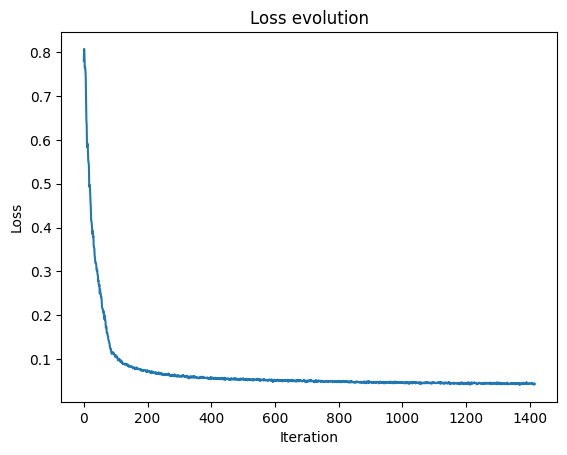

In [ ]:
# Guardar losses
losses = []

# épocas
epochs = 12

best_loss = 10000
k = 0
early_stopping = False
patience = 1e6

for i in range(epochs):
  # Iniciar tiempo de época
  start_time = time.time()

  for X, _ in train_loader:

    optim.zero_grad()

    # Ootput bfn
    loss = bfn.process(X.to(device))

    loss.backward()

    optim.step()

    ema.update()

    # Añadir loss a lista
    losses.append(loss.item())

    if loss.item() < best_loss:
      best_loss = loss.item()
      k = 0
      # Finalizar tiempo de época
      end_time = time.time()
    else:
      k += 1
      if k == patience:
        k = 0
        early_stopping = True
        # Finalizar tiempo de época
        end_time = time.time()
        break

  # Preguntar early stopping
  if early_stopping:
    # Finalizar tiempo de época
    end_time = time.time()
    break

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {i+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tLoss: {loss.item():.3f}')

# Plotear trayectoria de loss
plt.plot(losses)
plt.title('Loss evolution')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

Como se puede ver en el gráfico de arriba, la función de pérdida tiende a bajar mientras pasan las iteraciones como es lo esperado en estos casos. Esto es un buen indicio a que la red está aprendiendo de buena forma y que puede eventualmente ser capaz de generar dígitos como se espera.

In [ ]:
# Cantidad de imágenes a generar
batch_size = 9
# Definir los samples
x_hat = bfn.sample(device='cuda', nb_steps=1000, batch_size=batch_size, ema=ema)

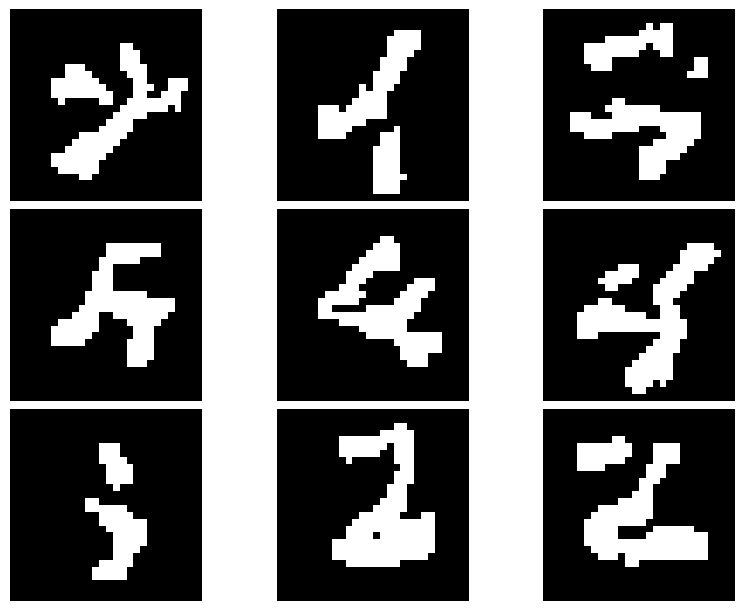

In [ ]:
# Graficar samples
size = int(np.sqrt(batch_size))
fig, ax = plt.subplots(size, size, figsize=(8, 6),  layout='constrained')

for i in range(batch_size):
  ax[i // size, i % size].imshow(x_hat.cpu().numpy()[i], cmap='Greys_r')
  ax[i // size, i % size].axis('off')

En la imagen de arriba se puede ver como resulta la generación de 9 imágenes usando la bfn junto con la unet y el dataset de entrenamiento de MNIST usual.  
Notar que estos resultados están predispuestos a la capacidad computacional y al tiempo dispusto a esperar a que esta red termine su entrenamiento, por lo que con más tiempo y gpu estos resultados pueden seguir mejorando.

In [ ]:
# Generar sampleo aleatorio
x_0 = get_sample()[0][0]

# Guardar tiempo, input y predicciones
Ys = []
Ks = []
Ts = []

# We set t going from 0 to 2/3
for t in np.linspace(0.001, 0.667, 20):
  l, y, k, t_ = bfn.process(x_0[None, :, :, None].to(torch.int64).to(device), training=False, t=t)

  Ys.append(y.permute(0, 2, 1, 3).cpu().numpy()[0, :, :, 1])
  Ks.append(k.permute(0, 2, 1).cpu().numpy()[0])
  Ts.append(t)

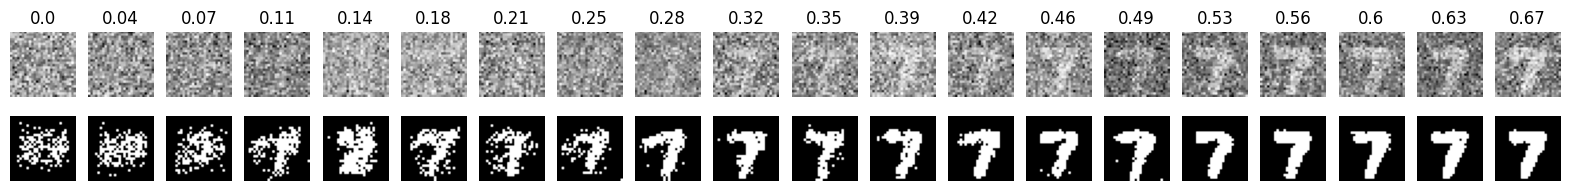

In [ ]:
# Plotear trayectoria de puntos
fig, ax = plt.subplots(2, 20, figsize=(20, 2))

for i in range(20):
  ax[0, i].imshow(Ys[i], cmap='Greys_r')
  ax[1, i].imshow(Ks[i], cmap='Greys_r')
  ax[0, i].axis('off')
  ax[1, i].axis('off')

  ax[0, i].set_title(np.round(Ts[i], 2))

Por último, en esta figura se puede observar el proceso llevado a cabo al generar un dato usando la BFN. Acá se pueden ver las similitudes con los modelos de difusión ya que ambos parten de una imagen ruidosa y haciéndola pequeñas modificaciones se puede ir generando un dígito.



---  

Ahora veamos el datset modificado de MNIST que presenta imágenes de 2 dígitos puestos en el plano:

In [ ]:
# Instanciar Bayesian Flow Network
bfn_2 = BayesianFlowNetwork2D(unet, 64, 2)
bfn_2.cuda()

# Definir optimizador
optim = AdamW(bfn_2.parameters(), lr=2e-4, betas=(0.9, 0.98), weight_decay=0.01)

# Exponential Moving Average
ema = torch_ema.ExponentialMovingAverage(bfn_2.net.parameters(), decay=0.9999)
ema.to(device)

Epoch: 01 | Epoch Time: 3m 11s
	Loss: 0.017
Epoch: 02 | Epoch Time: 0m 27s
	Loss: 0.017
Epoch: 03 | Epoch Time: 2m 35s
	Loss: 0.017
Epoch: 04 | Epoch Time: 1m 56s
	Loss: 0.016
Epoch: 05 | Epoch Time: 2m 20s
	Loss: 0.016
Epoch: 06 | Epoch Time: 2m 47s
	Loss: 0.016
Epoch: 07 | Epoch Time: 0m -37s
	Loss: 0.016
Epoch: 08 | Epoch Time: 3m 11s
	Loss: 0.015
Epoch: 09 | Epoch Time: 0m -13s
	Loss: 0.015
Epoch: 10 | Epoch Time: 0m 17s
	Loss: 0.015
Epoch: 11 | Epoch Time: -3m -6s
	Loss: 0.015
Epoch: 12 | Epoch Time: 0m 45s
	Loss: 0.015


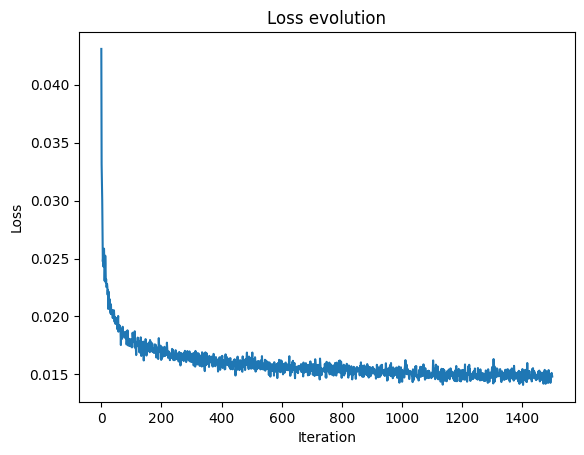

In [ ]:
# Guardar losses
losses_2 = []

# Definir épocas
epochs = 12

best_loss = 10000
k = 0
early_stopping = False
patience = 1e6

for i in range(epochs):
  # Iniciar tiempo de época
  start_time = time.time()

  # Leer dataset con dobles dígitos
  for X, _ in train_loader_2:

    # Deshacerse de la dimensión 2
    X = X.float().mean(2)

    optim.zero_grad()

    # Output bfn
    loss = bfn_2.process(X.to(device))

    loss.backward()

    optim.step()

    ema.update()

    # Añadir loss a lista
    losses_2.append(loss.item())

    if loss.item() < best_loss:
      best_loss = loss.item()
      k = 0
      # Finalzar tiempo de época
      end_time = time.time()
    else:
      k += 1
      if k == patience:
        k = 0
        early_stopping = True
        # Finalzar tiempo de época
        end_time = time.time()
        break

  # Preguntar early stopping
  if early_stopping:
    # Finalzar tiempo de época
    end_time = time.time()
    break

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {i+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tLoss: {loss.item():.3f}')

# Plotear trayectoria de loss
plt.plot(losses_2)
plt.title('Loss evolution')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

Al igual que antes, se puede ver como la loss baja al pasar las iteraciones, lo que es un buen indicio de que la red está aprendiendo y será capaz de entregar un resultado (por lo menos) decente.

In [ ]:
# Cantidad de samples
batch_size = 9

# Definir samples
x_hat = bfn_2.sample(device='cuda', nb_steps=1000, batch_size=batch_size, ema=ema)

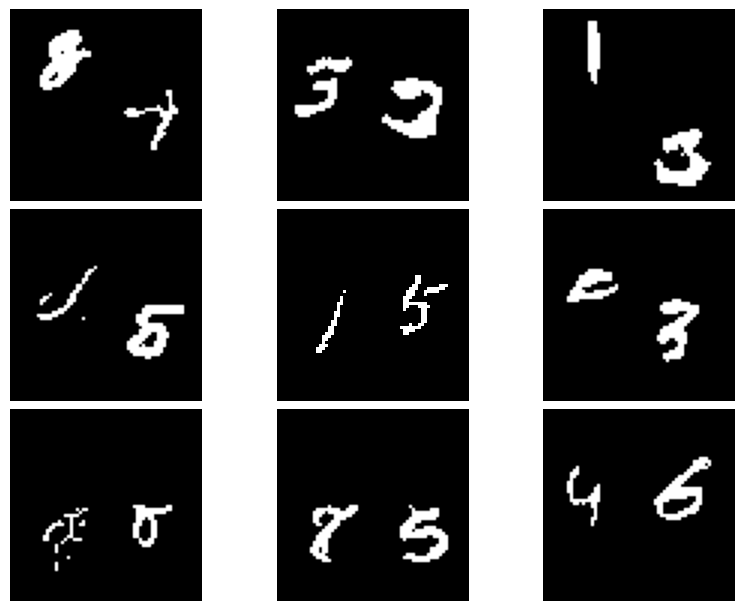

In [ ]:
# Graficar samples
size = int(np.sqrt(batch_size))
fig, ax = plt.subplots(size, size, figsize=(8, 6),  layout='constrained')

for i in range(batch_size):
  ax[i // size, i % size].imshow(x_hat.cpu().numpy()[i], cmap='Greys_r')
  ax[i // size, i % size].axis('off')

En la imagen de arriba se puede ver la generación de 9 datos, donde en este caso cada dato representa dos dígitos.  
Nuevamente, estos datos generados están predispuestos al tiempo el cual se deja entrenar la red, sin embargo, se puede ver como cada época de este entrenamiento toma mucho más tiempo que en el dataset de MNIST original por lo que ya se ve una gran dificultad en entrenar esta red por mucho tiempo.

In [ ]:
# Obtener sampleo aleatorio
x_0 = get_sample_2()[0][0][0]

# Guardar tiempo, input y predicciones
Ys = []
Ks = []
Ts = []

# We set t going from 0 to 2/3
for t in np.linspace(0.001, 0.667, 20):
  l, y, k, t_ = bfn_2.process(x_0[None, :, :, None].to(torch.int64).to(device), training=False, t=t)

  Ys.append(y.permute(0, 2, 1, 3).cpu().numpy()[0, :, :, 1])
  Ks.append(k.permute(0, 2, 1).cpu().numpy()[0])
  Ts.append(t)

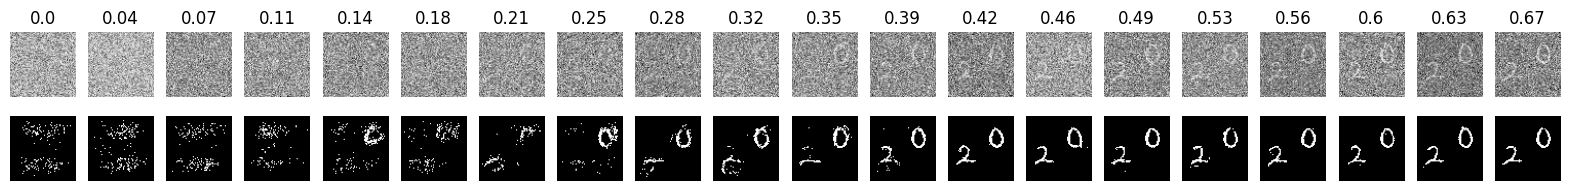

In [ ]:
# Plotear trayectoria de puntos
fig, ax = plt.subplots(2, 20, figsize=(20, 2))

for i in range(20):
  ax[0, i].imshow(Ys[i], cmap='Greys_r')
  ax[1, i].imshow(Ks[i], cmap='Greys_r')
  ax[0, i].axis('off')
  ax[1, i].axis('off')

  ax[0, i].set_title(np.round(Ts[i], 2))

Al igual que antes, es posible observar el mismo proceso que realiza la red para generar un dígito, donde se puede ver ahora que empiezan a aparecer 2 dígitos en cada imagen de entrada mientras que el output intenta reconstruir esta imagen.



---



**Conclusión:**  

En este proyecto se pudo implementar lo introducido en el paper de Bayesian Flow Networks de forma exitosa, usando el mismo dataset (MNIST) que se usó en el paper original. Por otra parte, como medida de aporte a este trabajo, se hizo prueba de un nuevo dataset que es una modificación de MNIST pudiendo generar de buena forma nuevos datos de este tipo.  
Por último, se considera que el proyecto de generación de dígitos usando BFN resultó un éxito haciendo un aporte al estado del arte de los modelos generativos.